# AlexNet

ImageNet Classification with Deep Convolutional Neural Networks: [URL](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [1]:
import torch
import torchvision.models as models

alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 93.3MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Data Augmentation

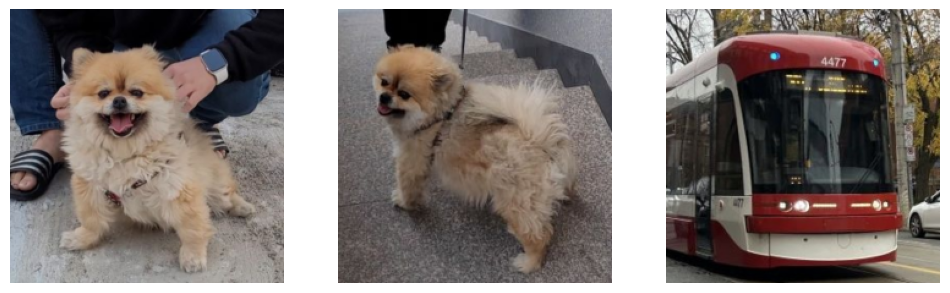

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

image_paths = ["dog1.jpg", "dog2.jpg", "streetcar.jpg"]
raw_images = [Image.open(img) for img in image_paths]

transform = transforms.Compose(
    [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]
)

images = [transform(img) for img in raw_images]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")

plt.show()

The first form of data augmentation consists of generating image translations and horizontal reflections.

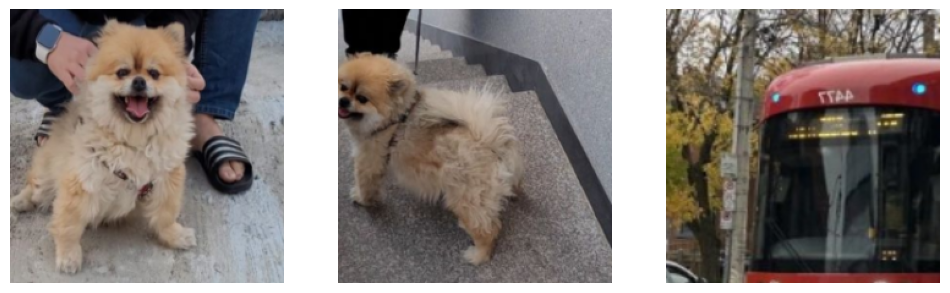

In [3]:
torch.manual_seed(0)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

images = [transform(img) for img in raw_images]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    img = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")

plt.show()

The second form of data augmentation consists of altering the intensities of the RGB channels in training images.

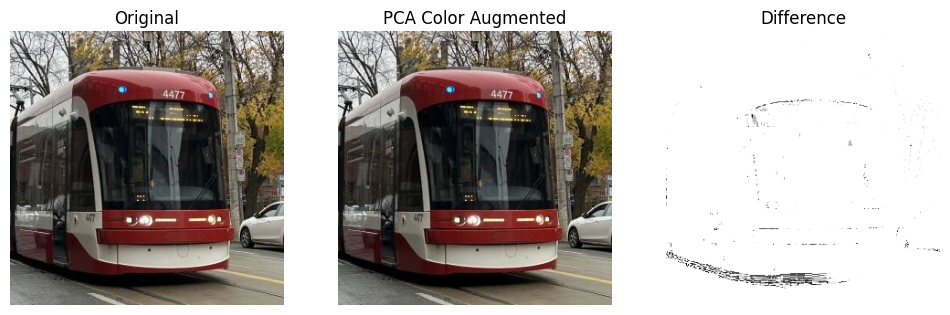

In [4]:
import numpy as np
import cv2

np.random.seed(42)


def pca_color_augmentation(image, alpha_std=0.1):
    img = image.astype(np.float32) / 255.0
    img_flat = img.reshape(-1, 3)

    mean = np.mean(img_flat, axis=0)
    img_flat -= mean
    cov = np.cov(img_flat, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)

    alpha = np.random.normal(0, alpha_std, size=(3,))
    delta = np.dot(eigvecs, eigvals * alpha)

    img_aug = img_flat + delta
    img_aug = np.clip(img_aug + mean, 0, 1)

    return (img_aug.reshape(image.shape) * 255).astype(np.uint8)


image = np.array(raw_images[2])
augmented_image = pca_color_augmentation(image)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(augmented_image)
ax[1].set_title("PCA Color Augmented")
ax[1].axis("off")

diff = cv2.absdiff(augmented_image, image)
diff = np.clip(diff * 10, 0, 255).astype(np.uint8)
diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
ax[2].imshow(diff, cmap="gray")
ax[2].set_title("Difference")
ax[2].axis("off")
plt.show()

## Qualitative Evaluations

 If two images produce feature activation vectors with a small Euclidean separation, we can say that the higher levels of the neural network consider them to be similar.

In [5]:
import requests

activation = {}


def hook(module, input, output):
    activation["fc7"] = output.detach()


alexnet.classifier[5].register_forward_hook(hook)

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

images = [transform(img) for img in raw_images]

feature_vectors = []
labels = []

for image in images:
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = alexnet(image)
        label = torch.argmax(output, dim=1).item()

    feature_vector = activation["fc7"].cpu().numpy().flatten()
    feature_vectors.append(feature_vector)
    labels.append(label)


def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)


url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(url).text.splitlines()

labels = [imagenet_classes[label] for label in labels]
v_dog1, v_dog2, v_flower = feature_vectors

distance1 = euclidean_distance(v_dog1, v_dog2)
distance2 = euclidean_distance(v_dog1, v_flower)

print(f"Distance[{labels[0]} - {labels[1]}]:", distance1)
print(f"Distance[{labels[0]} - {labels[2]}]:", distance2)

Distance[Pomeranian - Pomeranian]: 63.81385
Distance[Pomeranian - streetcar]: 107.640816
